# Unsupervised Learning: Clustering Lab





In [31]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
import math
import random

## 1. Implement the HAC and K-means algorithms
For both algorithms:
- Use euclidean distance as the distance metric
- You only need to handle continuous features, but think about how you would handle nominal and unknown data
---
When reporting the results of each algorithm, include the following:
- The number of clusters (*k*)
- The silhouette score of the full clustering (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)

For each cluster include:
- The vectors of points representing the cluster centroid
- The number of instances tied to that centroid
---

### 1.1 HAC (Hierarchical Agglomerative Clustering)

### HAC Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from *n* to 1.  To reduce the amount of output implement a mechanism to specify for which *k* values actual output will be generated.

In [8]:
class Cluster():
  num_clusters = 0
  def __init__(self, key=None, value=None):
    self.id = Cluster.num_clusters
    self.cluster_members = []
    Cluster.num_clusters += 1


  def addMember(self, id):
    self.cluster_members.extend(id.cluster_members)
    return
  
  def initMember(self, cluster):
    self.cluster_members.append(cluster)
    return

  def reset_num_cluster(self):
    Cluster.num_clusters = 0 
    return


class HACClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
        
    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        cluster_list = []
        for row in X:
          cluster = Cluster()
          cluster.initMember(cluster)
          cluster_list.append(cluster)
        dist_matrix = np.array([[0]*len(cluster_list)]*len(cluster_list), 'float32')
        for row in range(len(dist_matrix)):
          for col in range(len(dist_matrix[row])):
            vecx = X[cluster_list[row].id] 
            vecy = X[cluster_list[col].id] 
            euclid = 0
            for i in range(len(vecx)):
              euclid += (vecx[i]- vecy[i]) ** 2
            euclid = euclid ** 0.5
            dist_matrix[row][col] = euclid
        # print(dist_matrix)
        while len(cluster_list) > self.k:
          most_similar= ()
          dist = math.inf
          for clusterA in cluster_list:
            for clusterB in cluster_list:
              if clusterB in clusterA.cluster_members:
                continue
              else:
                # print(self.link_type)
                # print(dist)
                if self.link_type == 'single':
                  for a in clusterA.cluster_members:
                    for b in clusterB.cluster_members:
                      if dist > dist_matrix[a.id][b.id]:
                        dist = dist_matrix[a.id][b.id]
                        most_similar = (clusterA, clusterB)
                elif self.link_type == 'complete':
                  max_list = []
                  max = 0
                  max_tuple = []
                  # print('reset max')
                  for a in clusterA.cluster_members:
                    for b in clusterB.cluster_members:
                      # print(f'cluster a = {clusterA.id} cluster b = {clusterB.id}')
                      # print(f"distance from {a.id} to {b.id} is {dist_matrix[a.id][b.id]}")
                      if max < dist_matrix[a.id][b.id]:
                        # print(f"update max")
                        max = dist_matrix[a.id][b.id]
                        max_tuple = (a, b)
                        tup = (clusterA, clusterB)
                  # print(f"Complete Link dist between {clusterA.id} and {clusterB.id} is between {max_tuple[0].id} and {max_tuple[1].id} with a dist of {max}")
                  # print(f"the shortest found distance between two clusters is {dist}")
                  if dist > max:
                    # print(f" old dist = {dist} new dist = {max}")
                    dist = max
                    most_similar = tup
                else:
                  raise("Unknown method")
          # print(most_similar[0].id, most_similar[1].id)
          self.merge_clusters(most_similar)
          cluster_list.remove(most_similar[1])
          # print(len(cluster_list))
        # for cluster in cluster_list:
        #   for c in cluster.cluster_members:
        #     print(c.id)
        pred_labels = []
        pred_sum = [[0] * len(X[0])] * self.k
        for row in range(len(X)):
          prediction = None
          for cluster in range(len(cluster_list)):
            for c in  cluster_list[cluster].cluster_members:
              if c.id == row:
                prediction = cluster
                pred_sum[prediction] += X[row]
          pred_labels.append(prediction)
        s = silhouette_score(X, pred_labels, metric='euclidean')
        cluster_count = []
        for i in range(len(cluster_list)):
          cluster_count.append(pred_labels.count(i))
        for x in range(len(cluster_count)):
          pred_sum[x] = pred_sum[x] / cluster_count[x]
        self.results =  (len(cluster_list), s, cluster_count, pred_sum)
        cluster_list[0].reset_num_cluster()
        return self

    def merge_clusters(self, clusters):
      clusters[0].addMember(clusters[1])
      return

    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}\n".format(self.results[0]))
        print("Silhouette score: {:.4f}\n\n".format(self.results[1]))
        for count, centroid in zip(self.results[2], self.results[3]):
          print(np.array2string(centroid,precision=4,separator=","))
          print("{:d}\n".format(count))
        return

### 1.1.1 (15%) Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points are commented out.

- Include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit normalization, else you will not get the same answers as us.
- Report results for *k* = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link%20%28Silhouette%29.txt)

[Debug HAC Complete (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link%20%28Silhouette%29.txt)

In [ ]:
# Debug Here
from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output abalone.arff

train_data_unclean = arff.loadarff('abalone.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
normalized_abalone = train_data_from_scipy.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
abalone_np_data = normalized_abalone.to_numpy()

hac = HACClustering(k=5)
hac.fit(abalone_np_data)

hac.print_clusters()

Num clusters: 5

Silhouette score: 0.3453


[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1



In [ ]:
complete_link_hac = HACClustering(k=5, link_type='complete')
complete_link_hac.fit(abalone_np_data)

complete_link_hac.print_clusters()

Num clusters: 5

Silhouette score: 0.3095


[0.6544,0.649 ,0.5256,0.2879,0.2815,0.3057,0.2288,0.3911]
71

[0.3661,0.3505,0.271 ,0.1008,0.1024,0.1058,0.0836,0.2116]
67

[0.7622,0.7658,0.6759,0.4265,0.4016,0.4536,0.3376,0.5217]
38

[0.8818,0.8904,0.7582,0.614 ,0.5433,0.5317,0.561 ,0.7794]
16

[0.9471,0.934 ,0.8158,0.7457,0.6434,0.7944,0.6457,0.625 ]
8



Was able to match the debug results for both single link and complete link. I did not round the initial scores, but the presentation is rounded. I ran HAC until k=5 for both complete link and single link. The first output here is single link, the second is for complete link

### 1.1.2 (15%) Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

#### Complete Link

In [29]:
# Load evaluation data
# Train on evaluation data using complete link
# Print clusters
from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output bumps.arff

train_data_unclean = arff.loadarff('bumps.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0]).astype('float32')
normalized_bumps = train_data_from_scipy.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
bumps_np_data = normalized_bumps.to_numpy()

hac = HACClustering(k=5, link_type='complete')
hac.fit(bumps_np_data)

hac.print_clusters()

Num clusters: 5

Silhouette score: 0.2930


[0.3636,0.4107,0.5609,0.3857,0.3937,0.2808,0.3155,0.    ]
49

[0.3471,0.3622,0.7897,0.279 ,0.441 ,0.8568,0.2234,0.    ]
3

[0.1656,0.2226,0.3509,0.2328,0.152 ,0.3424,0.1918,0.    ]
18

[0.7918,0.8268,0.606 ,0.7669,0.7787,0.4634,0.7877,1.    ]
49

[0.5326,0.6002,0.4536,0.5531,0.5144,0.5401,0.6266,1.    ]
21



#### Single Link

In [30]:
# Load evaluation data
# Train on evaluation data using single link
# Print clusters
# Load evaluation data
# Train on evaluation data using complete link
# Print clusters
from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output bumps.arff

train_data_unclean = arff.loadarff('bumps.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0]).astype('float32')
normalized_bumps = train_data_from_scipy.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
bumps_np_data = normalized_bumps.to_numpy()

hac = HACClustering(k=5)
hac.fit(bumps_np_data)

hac.print_clusters()

Num clusters: 5

Silhouette score: 0.3971


[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1

[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70



Used the same hyper parameters for evaluation(ie k=5, both single and complete link, data normalized). The silhouette score for single link was much better than complete link in this case. Complete is reported first, single comes next.

### 1.2 K-means

### Code requirements 
- Ability to choose *k* and specify the *k* initial centroids
- Ability to handle distance ties--when a node or cluster has the same distance to another cluster, which should be rare, choose the earliest cluster in your list

In [34]:
class Cluster():
  num_clusters = 0
  def __init__(self, key=None, value=None):
    self.id = Cluster.num_clusters
    self.cluster_members = []
    Cluster.num_clusters += 1


  def addMember(self, id):
    self.cluster_members.extend(id.cluster_members)
    return
  
  def initMember(self, cluster):
    self.cluster_members.append(cluster)
    return
  
  def clearMembers(self):
    self.cluster_members = []
    return
  
  def reset_num_cluster(self):
    Cluster.num_clusters = 0 
    return

class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=True): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug

    def fit(self, X, y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        run = True
        cluster_list = []
        for i in range(self.k):
          cluster = Cluster()
          cluster_list.append(cluster)
        if self.debug:
          centroids = [X[i] for i in range(self.k)]
        else:
          randoms = [int(random.randint(0, len(X))) for i in range(4)]
          centroids = [X[i] for i in randoms]
        prev_centroids = [[0] * len(X[i])] * self.k
        while(run):
          pred_labels = []
          run = False
          for cluster in cluster_list:
            cluster.clearMembers()
          for row in X:
            dists = []
            for centroid in centroids:
              euclid = 0 
              for i in range(len(row)):
                euclid += (row[i]- centroid[i]) ** 2
              euclid = euclid ** 0.5
              dists.append(euclid)
            # print(cluster_list[np.argmin(dists)].id)
            # print(cluster_list[np.argmin(dists)].cluster_members)
            cluster_list[np.argmin(dists)].initMember(row)
            pred_labels.append(np.argmin(dists))
            # print(cluster_list[np.argmin(dists)].cluster_members)
          prev_centroids = centroids
          for cluster in cluster_list:
            # print(f"members of cluster {cluster.id}: {cluster.cluster_members}")
            new_centroid = [0] * len(X[0])
            for c in cluster.cluster_members:
              for i in range(len(c)):
                new_centroid[i] += c[i]
            for b in range(len(new_centroid)):
              new_centroid[b] = new_centroid[b] /len(cluster.cluster_members)
              # print(np.array(new_centroid).all() != np.array(centroids[cluster.id]).all())
              comparison = np.array(new_centroid) == np.array(centroids[cluster.id])
            if not comparison.all():
              # print(new_centroid)
              run = True
            centroids[cluster.id] = new_centroid
            # print(f"new centroid: {new_centroid}")
            # print(centroids)

        s = silhouette_score(X, pred_labels, metric='euclidean')

        cluster_count = []
        for cluster in cluster_list:
          cluster_count.append(len(cluster.cluster_members))


        self.results = (self.k, s, cluster_count, np.array(centroids))
        cluster_list[0].reset_num_cluster()
        return self
    
    def print_clusters(self):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}\n".format(self.results[0]))
        print("Silhouette score: {:.4f}\n\n".format(self.results[1]))
        for count, centroid in zip(self.results[2], self.results[3]):
          print(np.array2string(centroid,precision=4,separator=","))
          print("{:d}\n".format(count))
        return

### 1.2.1 (10%) K-Means Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)

- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit nomralization, else you will not get the same answers as us.
- Use *k* = 5
- Use the first *k* instances in the training set as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

---
Solution in file:

[Debug K Means (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means%20%28Silhouette%29.txt)

In [26]:
# Load debug data
# Train on debug data
# Print clusters
from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output abalone.arff

train_data_unclean = arff.loadarff('abalone.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
normalized_abalone = train_data_from_scipy.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
abalone_np_data = normalized_abalone.to_numpy()

kme = KMEANSClustering(k=5)
kme.fit(abalone_np_data)

kme.print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   988k      0 --:--:-- --:--:-- --:--:--  988k
Num clusters: 5

Silhouette score: 0.3845


[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.5893,0.7279]
24

[0.5692,0.5628,0.4376,0.211 ,0.2113,0.2248,0.1659,0.317 ]
54

[0.1296,0.1037,0.1053,0.0177,0.0211,0.0272,0.0135,0.0724]
13



Used the given hyperparameters (k=5, use first 5 as centroids) and was able to get the same results as kmeans debug dataset

### 1.2.2 (15%) K-Means Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

In [27]:
# Load evaluation data
# Train on evaluation data
# Print clusters
# Load debug data
# Train on debug data
# Print clusters
from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output bumps.arff

train_data_unclean = arff.loadarff('bumps.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0]).astype('float32')
normalized_bumps = train_data_from_scipy.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
bumps_np_data = normalized_bumps.to_numpy()

kme = KMEANSClustering(k=5)
kme.fit(bumps_np_data)

kme.print_clusters()

Num clusters: 5

Silhouette score: 0.2769


[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22

[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31

[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0.2413,0.    ]
20

[0.1634,0.2137,0.3968,0.2178,0.1555,0.3078,0.1775,0.    ]
19

[0.7961,0.831 ,0.6054,0.7709,0.7802,0.4553,0.7919,1.    ]
48



kmeans performed the worst of the three algorithms on silhouette score, but it was faster. IT was pretty close to complete link, so it may have been worth the trade off but certainly single link was the best if the goal was to get the best silhouette score

## 2. Iris Clustering with Both Alogrithms
For both algorithms: 
- Don't include the output label as one of the input features
- Normalize the data
- Show your results for clusterings with *k* = 2-7.  
- Graph the silhouette score for each *k* and discuss your results (i.e. what kind of clusters are being made).
- Load this Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

### 2.1 (10%) Iris Clustering with HAC

- Use single-link and complete link clustering algorithms
---

In [11]:
# Iris Clustering using single-link

from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

train_data_unclean = arff.loadarff('iris.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
train_data_from_scipy = train_data_from_scipy.iloc[:,:-1]
normalized_iris = train_data_from_scipy.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
iris_np_data = normalized_iris.to_numpy()

k_list = [2,3,4,5,6,7]
scores = []
for k in k_list:
  hac = HACClustering(k=k)
  hac.fit(iris_np_data)

  hac.print_clusters()
  scores.append(hac.results[1])


Num clusters: 2

Silhouette score: 0.6295


[0.1961,0.5908,0.0786,0.06  ]
50

[0.545 ,0.3633,0.662 ,0.6567]
100

Num clusters: 3

Silhouette score: 0.5309


[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.545 ,0.3633,0.662 ,0.6567]
100

Num clusters: 4

Silhouette score: 0.3883


[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.5363,0.3554,0.6563,0.6531]
98

[0.9722,0.75  ,0.9407,0.8333]
2

Num clusters: 5

Silhouette score: 0.2051


[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.5401,0.357 ,0.657 ,0.6529]
97

[0.1667,0.2083,0.5932,0.6667]
1

[0.9722,0.75  ,0.9407,0.8333]
2

Num clusters: 6

Silhouette score: 0.1605


[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]
1

[0.5373,0.3537,0.6548,0.6493]
96

[0.1667,0.2083,0.5932,0.6667]
1

[0.8056,0.6667,0.8644,1.    ]
1

[0.9722,0.75  ,0.9407,0.8333]
2

Num clusters: 7

Silhouette score: 0.1094


[0.199 ,0.6003,0.0792,0.0595]
49

[0.0556,0.125 ,0.0508,0.0833]


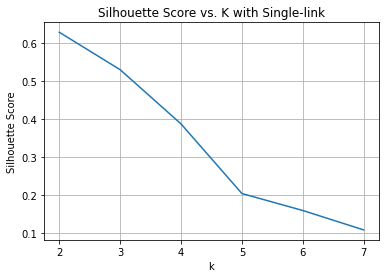

In [12]:
plt.plot(k_list, scores)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score vs. K with Single-link")
plt.grid()
plt.show()

In [13]:
# Iris Clustering using complete-link
# Iris Clustering using single-link

from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

train_data_unclean = arff.loadarff('iris.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
train_data_from_scipy = train_data_from_scipy.iloc[:,:-1]
normalized_iris = train_data_from_scipy.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
iris_np_data = normalized_iris.to_numpy()

k_list = [2,3,4,5,6,7]
scores = []
for k in k_list:
  hac = HACClustering(k=k, link_type='complete')
  hac.fit(iris_np_data)

  hac.print_clusters()
  scores.append(hac.results[1])

Num clusters: 2

Silhouette score: 0.4671


[0.2532,0.462 ,0.2377,0.212 ]
79

[0.624 ,0.4137,0.7233,0.7312]
71

Num clusters: 3

Silhouette score: 0.4635


[0.1961,0.5908,0.0786,0.06  ]
50

[0.624 ,0.4137,0.7233,0.7312]
71

[0.3515,0.2399,0.512 ,0.4741]
29

Num clusters: 4

Silhouette score: 0.3516


[0.2381,0.6619,0.0828,0.069 ]
35

[0.0981,0.425 ,0.0689,0.0389]
15

[0.624 ,0.4137,0.7233,0.7312]
71

[0.3515,0.2399,0.512 ,0.4741]
29

Num clusters: 5

Silhouette score: 0.3149


[0.2381,0.6619,0.0828,0.069 ]
35

[0.0981,0.425 ,0.0689,0.0389]
15

[0.575 ,0.4028,0.6901,0.7167]
60

[0.3515,0.2399,0.512 ,0.4741]
29

[0.8914,0.4735,0.9045,0.8106]
11

Num clusters: 6

Silhouette score: 0.3067


[0.2381,0.6619,0.0828,0.069 ]
35

[0.0981,0.425 ,0.0689,0.0389]
15

[0.5582,0.3789,0.6367,0.6016]
32

[0.3515,0.2399,0.512 ,0.4741]
29

[0.5942,0.4301,0.7512,0.8482]
28

[0.8914,0.4735,0.9045,0.8106]
11

Num clusters: 7

Silhouette score: 0.2876


[0.2089,0.5978,0.0789,0.0634]
23

[0.0981,0.425 ,0.0689,

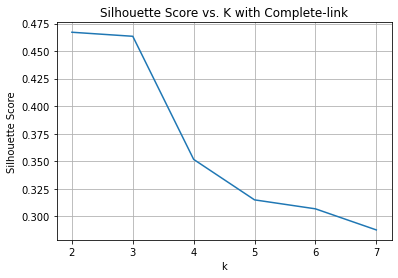

In [15]:
plt.plot(k_list, scores)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score vs. K with Complete-link")
plt.grid()
plt.show()

It looks like the best split in terms of silhouette score for both of these techniques was 2, maybe 3 clusters. Anymore and you start to just split off one or two from the largest clusters and it seriously weakened the score. THough it appears that single link is better for silhouette score, the complete link clusters tend to be more compact because it uses the largest distance rather than the shortest like single link. So depending on what your goal is the complete link could be the better approach.

### 2.2 (10%) Iris Clustering with K-means

In [20]:
# Iris Clustering with K-means
from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

train_data_unclean = arff.loadarff('iris.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
train_data_from_scipy = train_data_from_scipy.iloc[:,:-1]
normalized_iris = train_data_from_scipy.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
iris_np_data = normalized_iris.to_numpy()

k_list = [2,3,4,5,6,7]
scores = []
for k in k_list:
  kme = KMEANSClustering(k=k)
  kme.fit(iris_np_data)

  kme.print_clusters()
  scores.append(kme.results[1])

Num clusters: 2

Silhouette score: 0.6295


[0.545 ,0.3633,0.662 ,0.6567]
100

[0.1961,0.5908,0.0786,0.06  ]
50

Num clusters: 3

Silhouette score: 0.5043


[0.7073,0.4509,0.797 ,0.8248]
39

[0.4413,0.3074,0.5757,0.5492]
61

[0.1961,0.5908,0.0786,0.06  ]
50

Num clusters: 4

Silhouette score: 0.4016


[0.7073,0.4509,0.797 ,0.8248]
39

[0.4413,0.3074,0.5757,0.5492]
61

[0.2589,0.6949,0.0823,0.0774]
28

[0.1162,0.4583,0.074 ,0.0379]
22

Num clusters: 5

Silhouette score: 0.3667


[0.6716,0.4404,0.7604,0.7851]
51

[0.4133,0.2832,0.5597,0.523 ]
49

[0.2069,0.5958,0.0788,0.0708]
20

[0.1062,0.4289,0.0708,0.0343]
17

[0.297 ,0.7949,0.0887,0.0769]
13

Num clusters: 6

Silhouette score: 0.3501


[0.2257,0.6146,0.0773,0.0807]
16

[0.412 ,0.2769,0.559 ,0.5208]
48

[0.1358,0.4861,0.08  ,0.037 ]
18

[0.0278,0.3333,0.0466,0.0417]
4

[0.3032,0.8021,0.089 ,0.0729]
12

[0.6677,0.4431,0.7572,0.7821]
52

Num clusters: 7

Silhouette score: 0.3444


[0.2326,0.6068,0.0816,0.0807]
16

[0.412 ,0.2769,0.559 ,

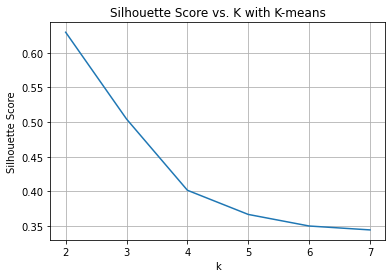

In [21]:
plt.plot(k_list, scores)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score vs. K with K-means")
plt.grid()
plt.show()

With k means using the first five instances as the initial  centroids, the silhouette score was great at clusters=2 and quickly nose dived after that. The way kmeans works is basically assigning all the instances to a centroid, then taking the average as the new centroid and running it again. So I guess the score could drop so much because the clusters are not so good and also because starting with bad centriods can change the score, and the more centroids you have the more likely you are to get a not so good one.

### 2.3 (5%) K-means Initial Centroids Experiment

- Run K-means 5 times with *k*=4, each time with different initial random centroids and discuss any variations in the results.
- If you ever end up with any empty clusters in K-means, re-run with different initial centroids

In [35]:
#K-means 5 times
from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

train_data_unclean = arff.loadarff('iris.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
train_data_from_scipy = train_data_from_scipy.iloc[:,:-1]
normalized_iris = train_data_from_scipy.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
iris_np_data = normalized_iris.to_numpy()

k_list = [0,1,2,3,4]
scores = []
for k in k_list:
  kme = KMEANSClustering(k=4, debug=False)
  kme.fit(iris_np_data)

  kme.print_clusters()
  scores.append(kme.results[1])

Num clusters: 4

Silhouette score: 0.4654


[0.2158,0.6266,0.0834,0.0721]
26

[0.5596,0.3733,0.6736,0.668 ]
96

[0.123 ,0.371 ,0.1308,0.1012]
21

[0.3413,0.8512,0.0799,0.0774]
7

Num clusters: 4

Silhouette score: 0.3890


[0.6677,0.4431,0.7572,0.7821]
52

[0.412 ,0.2769,0.559 ,0.5208]
48

[0.2996,0.7827,0.086 ,0.0744]
14

[0.1559,0.5162,0.0758,0.0544]
36

Num clusters: 4

Silhouette score: 0.3890


[0.1559,0.5162,0.0758,0.0544]
36

[0.6677,0.4431,0.7572,0.7821]
52

[0.412 ,0.2769,0.559 ,0.5208]
48

[0.2996,0.7827,0.086 ,0.0744]
14

Num clusters: 4

Silhouette score: 0.4435


[0.1961,0.5908,0.0786,0.06  ]
50

[0.3611,0.246 ,0.5156,0.4745]
31

[0.749 ,0.4769,0.8293,0.8673]
27

[0.5496,0.377 ,0.6626,0.6558]
42

Num clusters: 4

Silhouette score: 0.4446


[0.1961,0.5908,0.0786,0.06  ]
50

[0.5417,0.375 ,0.6566,0.6419]
42

[0.3563,0.2371,0.5091,0.4713]
29

[0.7385,0.4727,0.8229,0.8635]
29



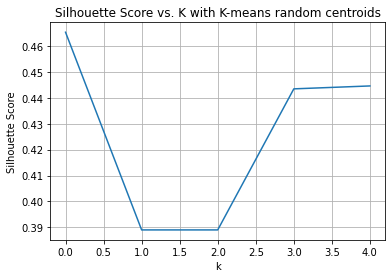

In [36]:
plt.plot(k_list, scores)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score vs. K with K-means random centroids")
plt.grid()
plt.show()

Clearly different centroids can have a significant change in silhouette score which also means general compactness but also distance from other clusters. This is all with 4 centroids, but just selecting different centroids to start each time. Both the total number of instances in each cluster and the silhouette score changed dramatically depending on the starting random centroids.

## 3. Scikit-Learn Comparison

### 3.1 (10%) Run the SK versions of HAC (just single link) and K-means on Iris data set above

- Report results for a couple values of *k*
- Experiment using different hyper-parameters

In [62]:
# Load sklearn
from scipy.io import arff
import pandas as pd

# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

train_data_unclean = arff.loadarff('iris.arff')
train_data_from_scipy = pd.DataFrame(train_data_unclean[0])
train_data_from_scipy = train_data_from_scipy.iloc[:,:-1]
normalized_iris = train_data_from_scipy.apply(lambda iterator: ((iterator - iterator.min())/(iterator.max() - iterator.min())))
iris_np_data = normalized_iris.to_numpy()

from sklearn.cluster import AgglomerativeClustering, KMeans

k_list = [2,3,5]

for k in k_list:
  agg = AgglomerativeClustering(linkage='single', n_clusters=k, affinity='Euclidean')
  agg.fit(iris_np_data)
  score = silhouette_score(iris_np_data, agg.labels_, metric='euclidean')
  print(f"Hac Score with k = {k}: {score}")


for k in k_list:
  kmeans = KMeans(n_clusters=k, algorithm='lloyd')
  kmeans.fit(iris_np_data)
  score = silhouette_score(iris_np_data, kmeans.labels_, metric='euclidean')
  print(f"\nKmeans score with k = {k}: {score}\n")
  print(kmeans.cluster_centers_)

Hac Score with k = 2: 0.6294675561906643
Hac Score with k = 3: 0.530889323901593
Hac Score with k = 5: 0.2051017399323444

Kmeans score with k = 2: 0.6294675561906643

[[0.545      0.36333333 0.6620339  0.65666667]
 [0.19611111 0.59083333 0.07864407 0.06      ]]

Kmeans score with k = 3: 0.5043188549150883

[[0.70726496 0.4508547  0.79704476 0.82478632]
 [0.19611111 0.59083333 0.07864407 0.06      ]
 [0.44125683 0.30737705 0.57571548 0.54918033]]

Kmeans score with k = 5: 0.35349069924463267

[[0.36111111 0.24596774 0.51558229 0.47446237]
 [0.11616162 0.45833333 0.07395994 0.03787879]
 [0.54960317 0.37698413 0.66263115 0.65575397]
 [0.25892857 0.69494048 0.08232446 0.07738095]
 [0.74897119 0.47685185 0.82925298 0.86728395]]


Both had the best silhouette score with 2 clusters, same as my results. Its worth noting that with k=5, the kmeans performs better than the HAC. It also goes a long way to show that clustering is not perfect because with iris we know that there are three classes and yet both algorithms prefer two clusters. Goes to show that just because something gets a good silhouette score doesn't mean that is ground truth. Just a good clustering option. I also tried HAC with different affinities, Euclidean performed best followed by Manhattan. Kmeans I tried with a few different algorithms with lloyd performing the best, so I reported with those params at the end here.

### 3.2 (10%) Run the SK version of HAC (just single link) and K-means on a dataset of your choice 
- Report results for a couple values of *k*
- Experiment using different hyper-parameters

In [63]:
# Load sklearn 

from sklearn.cluster import AgglomerativeClustering, KMeans
# !curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff --output linsep2nonorigin.arff

test_data_unclean = arff.loadarff('linsep2nonorigin.arff')
test_data_from_scipy = pd.DataFrame(test_data_unclean[0])
linsep_np_data = test_data_from_scipy.to_numpy()
linsep_np_data = linsep_np_data.astype(float)

k_list = [2,3,5]

for k in k_list:
  agg = AgglomerativeClustering(linkage='single', n_clusters=k, affinity='euclidean')
  agg.fit(linsep_np_data)
  score = silhouette_score(linsep_np_data, agg.labels_, metric='euclidean')
  print(f"Hac Score for k = {k}: {score}")

for k in k_list:
  kmeans = KMeans(n_clusters=k, algorithm='lloyd')
  kmeans.fit(linsep_np_data)
  score = silhouette_score(linsep_np_data, kmeans.labels_, metric='euclidean')
  print(f"\nKmeans score for k = {k}: {score}\n")
  print(kmeans.cluster_centers_)

Hac Score for k = 2: 0.6833225109750054
Hac Score for k = 3: 0.6672300283101531
Hac Score for k = 5: 0.4247264293672931

Kmeans score for k = 2: 0.6833225109750054

[[ 0.05  -0.025  0.   ]
 [-0.25   0.575  1.   ]]

Kmeans score for k = 3: 0.6672300283101531

[[-0.3    0.3    1.   ]
 [ 0.05  -0.025  0.   ]
 [-0.2    0.85   1.   ]]

Kmeans score for k = 5: 0.3802604031311132

[[ 0.    0.15  0.  ]
 [-0.3   0.8   1.  ]
 [-0.3   0.3   1.  ]
 [ 0.1  -0.2   0.  ]
 [-0.1   0.9   1.  ]]


Both got pretty good silhouette score on the linsep data for 2 and 3 clusters, but 2 was the best. THis was the highest silhouette score I had seen today, but it makes sense since the data is linearly seperable. I tried a few different hyperparameters for this dataset as well. They all performed pretty well but I reported the best. Turns out clustering works well for linearly seperable data- especially if you use the target as a feature.

## 4. (Optional 5% extra credit) Write your own code for silhouette
If you do this option implement your code for silhouette above in your main implementation and use it for your experements. Make it clear that the silhouette results come from your code. You may/should compare with the SK version to debug/verify your results.

*Discussion*